# Accuracy Test for aditeyabaral-sentencetransformer-indic-bert

Big Data Final Project | 4/25/23

Nick Kalenichenko, Eve Schoenrock, Rachel Grace Treene

This notebook shows the implementation of our testing protocol for the aditeyabaral-sentencetransformer-indic-bert Hugging Face model compared with its force-saved space version and its optionally-saved space version. Future testing of resized/regenerated models can be based on this notebook, but customized for each model's functionality.

The test text comes from the wikipedia page: https://en.wikipedia.org/wiki/Moon_landing

In [1]:
import nltk
import pandas as pd
from sentence_transformers import SentenceTransformer
from nltk.cluster import KMeansClusterer
import numpy as np

from transformers import AutoTokenizer, AutoModel
import torch

from scipy.spatial import distance_matrix

# Functional Implementation of Model Comparison

In [2]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# function to compare output summaries of differening state dicts
def compare_performance(current_mod, new_state_dict, text_list, num_clusters=3, iterations=25):
    
    data = pd.DataFrame(text_list)
    data.columns = ['sentence']
    
    # Load model from HuggingFace Hub
    tokenizer = AutoTokenizer.from_pretrained(current_mod)
    my_model = AutoModel.from_pretrained(current_mod) # specify model 
    
    # PRIOR TO NEW STATE DICT
    # Tokenize sentences
    encoded_input = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings
    with torch.no_grad():
        model_output = my_model(**encoded_input)
    # Perform pooling. In this case, mean pooling.
    sentence_embeddings_og = mean_pooling(model_output, encoded_input['attention_mask'])
    list_sent_embeddings_og = sentence_embeddings_og.tolist()
    data['embeddings_og'] = list_sent_embeddings_og # column for original embeddings
    
    # working state dict switch
    state_dict = torch.load(new_state_dict) # file path
    condition = ['encoder.albert_layer_groups.0.albert_layers.0.attention.query.labels',
                 'encoder.albert_layer_groups.0.albert_layers.0.attention.key.labels',
                 'encoder.albert_layer_groups.0.albert_layers.0.attention.value.labels',
                 'encoder.albert_layer_groups.0.albert_layers.0.attention.sizes']

    new_state_dict = state_dict.copy()   
    for key in list(new_state_dict):
        if key in condition:
            del new_state_dict[key]
    
    my_model.load_state_dict(new_state_dict)
    
    
    # AFTER NEW STATE DICT
    # Tokenize sentences
    encoded_input = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings
    with torch.no_grad():
        model_output = my_model(**encoded_input)
    # Perform pooling. In this case, mean pooling.
    sentence_embeddings_new = mean_pooling(model_output, encoded_input['attention_mask'])
    list_sent_embeddings_new = sentence_embeddings_new.tolist()
    data['embeddings_new'] = list_sent_embeddings_new # column for new sentence embeddings
    
    # metrics of success
    # OG STATE DICT
    # cluster
    NUM_CLUSTERS = num_clusters # number of sentences to be outputted
    iterations = iterations
    X = np.array(data['embeddings_og'].tolist())
 
    kclusterer = KMeansClusterer(
            NUM_CLUSTERS, distance = nltk.cluster.util.cosine_distance,
            repeats = iterations,avoid_empty_clusters=True)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    data['cluster_og'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid_og'] = data['cluster_og'].apply(lambda x: kclusterer.means()[x])

    def distance_from_centroid(row):
        #type of emb and centroid is different, hence using tolist below
        return distance_matrix([row['embeddings_og']], [row['centroid_og'].tolist()])[0][0]
 
    data['distance_from_centroid_og'] = data.apply(distance_from_centroid, axis=1)

    # NEW STATE DICT
    X = np.array(data['embeddings_new'].tolist())
    
    kclusterer = KMeansClusterer(
            NUM_CLUSTERS, distance = nltk.cluster.util.cosine_distance,
            repeats = iterations,avoid_empty_clusters=True)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    data['cluster_new'] = pd.Series(assigned_clusters, index = data.index)
    data['centroid_new'] = data['cluster_new'].apply(lambda x: kclusterer.means()[x])

    def distance_from_centroid(row):
        #type of emb and centroid is different, hence using tolist below
        return distance_matrix([row['embeddings_new']], [row['centroid_new'].tolist()])[0][0]
 
    data['distance_from_centroid_new'] = data.apply(distance_from_centroid, axis=1)
    
    # generate summaries df
    summary_og = ' '.join(data.sort_values('distance_from_centroid_og',ascending = True).groupby('cluster_og').head(1).sort_index()['sentence'].tolist())
    summary_new = ' '.join(data.sort_values('distance_from_centroid_new',ascending = True).groupby('cluster_new').head(1).sort_index()['sentence'].tolist())
    summary_list = [summary_og, summary_new]
    summaries = pd.DataFrame(list(zip(['og_summary', 'new_summary'], summary_list)))
    summaries.columns = ['type', 'summary']
    
    
    return data, summaries

In [3]:
def print_side_by_side(a, b, size=30, space=4):
    while a or b:
        print(a[:size].ljust(size) + " " * space + b[:size])
        a = a[size:]
        b = b[size:]

## Compare Original and Optionally Replaced State Dictionaries

### **Short Text**: Moon Landing Wikipedia

In [4]:
# optional/original comparison
current_mod = 'aditeyabaral/sentencetransformer-indic-bert'
new_state_dict = 'working_aditeyabaral_sent_trans/pytorch_model_mod_opt.bin'
wiki = ["A Moon landing is the arrival of a spacecraft on the surface of the Moon.",
        "This includes both crewed and robotic missions.",
        "The first human-made object to touch the Moon was the Soviet Union's Luna 2, on 13 September 1959.",
        "The United States' Apollo 11 was the first crewed mission to land on the Moon, on 20 July 1969.",
        "There were six crewed U.S. landings between 1969 and 1972, and numerous uncrewed landings, with no soft landings happening between 22 August 1976 and 14 December 2013.",
        "The United States is the only country to have successfully conducted crewed missions to the Moon, with the last departing the lunar surface in December 1972.",
        "All soft landings took place on the near side of the Moon until 3 January 2019, when the Chinese Chang'e 4 spacecraft made the first landing on the far side of the Moon."]
clusters = 3
its = 30

comparison = compare_performance(current_mod, new_state_dict, wiki, num_clusters=clusters, iterations=its)
metric_df1 = comparison[0]
summary_df1 = comparison[1]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [5]:
metric_df1

,sentence,embeddings_og,embeddings_new,cluster_og,centroid_og,distance_from_centroid_og,cluster_new,centroid_new,distance_from_centroid_new
0,A Moon landing is the arrival of a spacecraft ...,"[0.09028150141239166, -0.061700429767370224, -...","[-0.5102444887161255, 0.22721631824970245, 0.6...",0,"[0.08915513047465572, -0.06220522934088, -0.02...",0.058158,1,"[-0.5102444887161255, 0.22721633687615395, 0.6...",9.914837e-07
1,This includes both crewed and robotic missions.,"[0.08807971328496933, -0.06278901547193527, -0...","[-0.5102444291114807, 0.22721624374389648, 0.6...",0,"[0.08915513047465572, -0.06220522934088, -0.02...",0.060658,0,"[-0.5102445483207703, 0.22721630334854126, 0.6...",1.151732e-06
2,The first human-made object to touch the Moon ...,"[0.08922849595546722, -0.06166686490178108, -0...","[-0.5102444887161255, 0.22721637785434723, 0.6...",1,"[0.08846235682722181, -0.06089407246327028, -0...",0.016931,1,"[-0.5102444887161255, 0.22721633687615395, 0.6...",5.715972e-07
3,The United States' Apollo 11 was the first cre...,"[0.08798035234212875, -0.06042402237653732, -0...","[-0.5102444887161255, 0.22721627354621887, 0.6...",1,"[0.08846235682722181, -0.06089407246327028, -0...",0.012972,1,"[-0.5102444887161255, 0.22721633687615395, 0.6...",8.183393e-07
4,There were six crewed U.S. landings between 19...,"[0.09151201695203781, -0.06364540010690689, -0...","[-0.5102444887161255, 0.22721630334854126, 0.6...",2,"[0.09287737171958994, -0.06330413040187623, -0...",0.024886,2,"[-0.5102444688479105, 0.2272163132826487, 0.66...",3.437351e-07
5,The United States is the only country to have ...,"[0.08814173936843872, -0.06055453047156334, -0...","[-0.510244607925415, 0.22721633315086365, 0.66...",1,"[0.08846235682722181, -0.06089407246327028, -0...",0.021957,0,"[-0.5102445483207703, 0.22721630334854126, 0.6...",5.758662e-07
6,All soft landings took place on the near side ...,"[0.09427686035633087, -0.06295432895421982, -0...","[-0.5102444291114807, 0.22721633315086365, 0.6...",2,"[0.09287737171958994, -0.06330413040187623, -0...",0.025508,2,"[-0.5102444688479105, 0.2272163132826487, 0.66...",6.874703e-07


We see that sentences are assigned to different clusters between the original and new models. 

Clusters designate sentence groupings that can be chosen from for creation of the final summary. Assignment of clusters matters for this reason - differences alter the potential summary. Aside from this, and likely most notable for determining differences caused by using an efficient state dictionary, are the distance from centroid measures. This measure is an estimation of the centroid vector.

Specifically, a smaller distance from centroid indicates greater importance of a sentence. The process of generating a summary is to first cluster by cluster assignment and then choose the sentence with the smallest distance from centroid value out of that cluster.

We find that distance from the centroid greatly differs between the original and new state dictionaries. This is to be anticipated since we have manipulated the mathematically obtained state dictionary. Speculation surrounding the solutions to these differences are out of the scope of this project. However, this is cause for concern, and it should be evaluated further.

References:
- *https://www.sciencedirect.com/science/article/abs/pii/S0957417420308952*
- *https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10036244/*
- *https://aclanthology.org/W16-2915.pdf*

In [6]:
summary_df1

,type,summary
0,og_summary,A Moon landing is the arrival of a spacecraft ...
1,new_summary,The first human-made object to touch the Moon ...


In [7]:
og_sum = summary_df1['summary'][0]
new_sum = summary_df1['summary'][1]

print('Original Text:\n', og_sum, '\n', sep='')
print('New Summary:\n', new_sum, sep='')

Original Text:
A Moon landing is the arrival of a spacecraft on the surface of the Moon. The United States' Apollo 11 was the first crewed mission to land on the Moon, on 20 July 1969. There were six crewed U.S. landings between 1969 and 1972, and numerous uncrewed landings, with no soft landings happening between 22 August 1976 and 14 December 2013.

New Summary:
The first human-made object to touch the Moon was the Soviet Union's Luna 2, on 13 September 1959. There were six crewed U.S. landings between 1969 and 1972, and numerous uncrewed landings, with no soft landings happening between 22 August 1976 and 14 December 2013. The United States is the only country to have successfully conducted crewed missions to the Moon, with the last departing the lunar surface in December 1972.


### **Long Text**: Moon Landing Wikipedia

In [8]:
# optional/original comparison
current_mod = 'aditeyabaral/sentencetransformer-indic-bert'
new_state_dict = 'working_aditeyabaral_sent_trans/pytorch_model_mod_opt.bin'
wiki2 = ["To get to the Moon, a spacecraft must first leave Earth's gravity well; currently, the only practical means is a rocket.",
         "Unlike airborne vehicles such as balloons and jets, a rocket can continue accelerating in the vacuum outside the atmosphere.",
         "Upon approach of the target moon, a spacecraft will be drawn ever closer to its surface at increasing speeds due to gravity.",
         "In order to land intact it must decelerate to less than about 160 kilometres per hour (99 mph) and be ruggedized to withstand a 'hard landing' impact, or it must decelerate to negligible speed at contact for a 'soft landing' (the only option for humans).",
         "The first three attempts by the U.S. to perform a successful hard Moon landing with a ruggedized seismometer package in 1962 all failed.",
         "The Soviets first achieved the milestone of a hard lunar landing with a ruggedized camera in 1966, followed only months later by the first uncrewed soft lunar landing by the U.S.",
         "The speed of a crash landing on its surface is typically between 70 and 100% of the escape velocity of the target moon, and thus this is the total velocity which must be shed from the target moon's gravitational attraction for a soft landing to occur.",
         "For Earth's Moon, the escape velocity is 2.38 kilometres per second (1.48 mi/s).[9] The change in velocity (referred to as a delta-v) is usually provided by a landing rocket, which must be carried into space by the original launch vehicle as part of the overall spacecraft.",
         "An exception is the soft moon landing on Titan carried out by the Huygens probe in 2005.",
         "As the moon with the thickest atmosphere, landings on Titan may be accomplished by using atmospheric entry techniques that are generally lighter in weight than a rocket with equivalent capability.",
         "The Soviets succeeded in making the first crash landing on the Moon in 1959.",
         "Crash landings may occur because of malfunctions in a spacecraft, or they can be deliberately arranged for vehicles which do not have an onboard landing rocket.",
         "There have been many such Moon crashes, often with their flight path controlled to impact at precise locations on the lunar surface.",
         "For example, during the Apollo program the S-IVB third stage of the Saturn V rocket as well as the spent ascent stage of the Lunar Module were deliberately crashed on the Moon several times to provide impacts registering as a moonquake on seismometers that had been left on the lunar surface.",
         "Such crashes were instrumental in mapping the internal structure of the Moon.",
         "To return to Earth, the escape velocity of the Moon must be overcome for the spacecraft to escape the gravity well of the Moon.",
         "Rockets must be used to leave the Moon and return to space.",
         "Upon reaching Earth, atmospheric entry techniques are used to absorb the kinetic energy of a returning spacecraft and reduce its speed for safe landing.",
         "These functions greatly complicate a moon landing mission and lead to many additional operational considerations.",
         "Any moon departure rocket must first be carried to the Moon's surface by a moon landing rocket, increasing the latter's required size.",
         "The Moon departure rocket, larger moon landing rocket and any Earth atmosphere entry equipment such as heat shields and parachutes must in turn be lifted by the original launch vehicle, greatly increasing its size by a significant and almost prohibitive degree."]
clusters = 3
its = 30

comparison = compare_performance(current_mod, new_state_dict, wiki2, num_clusters=clusters, iterations=its)
metric_df2 = comparison[0]
summary_df2 = comparison[1]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [9]:
metric_df2

,sentence,embeddings_og,embeddings_new,cluster_og,centroid_og,distance_from_centroid_og,cluster_new,centroid_new,distance_from_centroid_new
0,"To get to the Moon, a spacecraft must first le...","[0.08796011656522751, -0.06341452896595001, -0...","[-0.5102444887161255, 0.22721630334854126, 0.6...",1,"[0.08780379511415959, -0.06241400453365511, -0...",0.033205,1,"[-0.5102445024710435, 0.22721630793351394, 0.6...",8.238540e-07
1,Unlike airborne vehicles such as balloons and ...,"[0.08885730803012848, -0.0640578344464302, -0....","[-0.5102444887161255, 0.22721634805202484, 0.6...",0,"[0.08898894215116696, -0.06267445608321849, -0...",0.040025,1,"[-0.5102445024710435, 0.22721630793351394, 0.6...",8.303863e-07
2,"Upon approach of the target moon, a spacecraft...","[0.08778734505176544, -0.06264067441225052, -0...","[-0.5102444887161255, 0.22721630334854126, 0.6...",1,"[0.08780379511415959, -0.06241400453365511, -0...",0.024536,1,"[-0.5102445024710435, 0.22721630793351394, 0.6...",8.563083e-07
3,In order to land intact it must decelerate to ...,"[0.0908321812748909, -0.06549391150474548, -0....","[-0.5102444887161255, 0.22721634805202484, 0.6...",2,"[0.0926172863882111, -0.065207789471487, -0.02...",0.056708,1,"[-0.5102445024710435, 0.22721630793351394, 0.6...",6.590503e-07
4,The first three attempts by the U.S. to perfor...,"[0.08536101877689362, -0.06161920353770256, -0...","[-0.5102445483207703, 0.22721634805202484, 0.6...",1,"[0.08780379511415959, -0.06241400453365511, -0...",0.069360,1,"[-0.5102445024710435, 0.22721630793351394, 0.6...",7.891666e-07
5,The Soviets first achieved the milestone of a ...,"[0.09243759512901306, -0.06321981549263, -0.02...","[-0.5102444887161255, 0.22721630334854126, 0.6...",2,"[0.0926172863882111, -0.065207789471487, -0.02...",0.043664,1,"[-0.5102445024710435, 0.22721630793351394, 0.6...",1.004437e-06
6,The speed of a crash landing on its surface is...,"[0.09206081926822662, -0.06451454013586044, -0...","[-0.5102444887161255, 0.22721633315086365, 0.6...",2,"[0.0926172863882111, -0.065207789471487, -0.02...",0.025636,2,"[-0.5102444738149643, 0.22721631824970245, 0.6...",7.394742e-07
7,"For Earth's Moon, the escape velocity is 2.38 ...","[0.09510201215744019, -0.06708868592977524, -0...","[-0.510244607925415, 0.22721631824970245, 0.66...",2,"[0.0926172863882111, -0.065207789471487, -0.02...",0.055118,1,"[-0.5102445024710435, 0.22721630793351394, 0.6...",6.241676e-07
8,An exception is the soft moon landing on Titan...,"[0.08933964371681213, -0.062041718512773514, -...","[-0.5102444887161255, 0.22721628844738007, 0.6...",0,"[0.08898894215116696, -0.06267445608321849, -0...",0.042670,1,"[-0.5102445024710435, 0.22721630793351394, 0.6...",7.514797e-07
9,"As the moon with the thickest atmosphere, land...","[0.08822794258594513, -0.0630001649260521, -0....","[-0.5102444887161255, 0.22721630334854126, 0.6...",1,"[0.08780379511415959, -0.06241400453365511, -0...",0.034834,0,"[-0.5102445312908718, 0.2272163097347532, 0.66...",8.051106e-07


In [10]:
summary_df2

,type,summary
0,og_summary,The speed of a crash landing on its surface is...
1,new_summary,"For Earth's Moon, the escape velocity is 2.38 ..."


In [11]:
og_sum = summary_df2['summary'][0]
new_sum = summary_df2['summary'][1]

print('Original Text:\n', og_sum, '\n', sep='')
print('New Summary:\n', new_sum, sep='')

Original Text:
The speed of a crash landing on its surface is typically between 70 and 100% of the escape velocity of the target moon, and thus this is the total velocity which must be shed from the target moon's gravitational attraction for a soft landing to occur. The Soviets succeeded in making the first crash landing on the Moon in 1959. Upon reaching Earth, atmospheric entry techniques are used to absorb the kinetic energy of a returning spacecraft and reduce its speed for safe landing.

New Summary:
For Earth's Moon, the escape velocity is 2.38 kilometres per second (1.48 mi/s).[9] The change in velocity (referred to as a delta-v) is usually provided by a landing rocket, which must be carried into space by the original launch vehicle as part of the overall spacecraft. Crash landings may occur because of malfunctions in a spacecraft, or they can be deliberately arranged for vehicles which do not have an onboard landing rocket. To return to Earth, the escape velocity of the Moon mu

## Compare Original and Force Replace State Dictionaries

### **Short Text**: Moon Landing Wikipedia

In [12]:
current_mod = 'aditeyabaral/sentencetransformer-indic-bert'
new_state_dict = 'working_aditeyabaral_sent_trans/pytorch_model_mod.bin'
wiki = ["A Moon landing is the arrival of a spacecraft on the surface of the Moon.",
        "This includes both crewed and robotic missions.",
        "The first human-made object to touch the Moon was the Soviet Union's Luna 2, on 13 September 1959.",
        "The United States' Apollo 11 was the first crewed mission to land on the Moon, on 20 July 1969.",
        "There were six crewed U.S. landings between 1969 and 1972, and numerous uncrewed landings, with no soft landings happening between 22 August 1976 and 14 December 2013.",
        "The United States is the only country to have successfully conducted crewed missions to the Moon, with the last departing the lunar surface in December 1972.",
        "All soft landings took place on the near side of the Moon until 3 January 2019, when the Chinese Chang'e 4 spacecraft made the first landing on the far side of the Moon."]
clusters = 3 # include only 3 sentences
its = 30

comparison = compare_performance(current_mod, new_state_dict, wiki, num_clusters=clusters, iterations=its)
metric_df3 = comparison[0]
summary_df3 = comparison[1]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
metric_df3

,sentence,embeddings_og,embeddings_new,cluster_og,centroid_og,distance_from_centroid_og,cluster_new,centroid_new,distance_from_centroid_new
0,A Moon landing is the arrival of a spacecraft ...,"[0.09028150141239166, -0.061700429767370224, -...","[-0.5112084746360779, 0.22222235798835754, 0.6...",0,"[0.08915513047465572, -0.06220522934088, -0.02...",0.058158,1,"[-0.5112085044384003, 0.22222227603197098, 0.6...",1.051267e-06
1,This includes both crewed and robotic missions.,"[0.08807971328496933, -0.06278901547193527, -0...","[-0.5112085342407227, 0.22222232818603516, 0.6...",0,"[0.08915513047465572, -0.06220522934088, -0.02...",0.060658,0,"[-0.5112085193395615, 0.22222232818603516, 0.6...",1.066197e-06
2,The first human-made object to touch the Moon ...,"[0.08922849595546722, -0.06166686490178108, -0...","[-0.5112085342407227, 0.22222232818603516, 0.6...",1,"[0.08846235682722181, -0.06089407246327028, -0...",0.016931,0,"[-0.5112085193395615, 0.22222232818603516, 0.6...",5.265841e-07
3,The United States' Apollo 11 was the first cre...,"[0.08798035234212875, -0.06042402237653732, -0...","[-0.5112084746360779, 0.22222229838371277, 0.6...",1,"[0.08846235682722181, -0.06089407246327028, -0...",0.012972,1,"[-0.5112085044384003, 0.22222227603197098, 0.6...",1.069286e-06
4,There were six crewed U.S. landings between 19...,"[0.09151201695203781, -0.06364540010690689, -0...","[-0.5112085342407227, 0.22222228348255157, 0.6...",2,"[0.09287737171958994, -0.06330413040187623, -0...",0.024886,2,"[-0.5112085342407227, 0.22222228348255157, 0.6...",0.000000e+00
5,The United States is the only country to have ...,"[0.08814173936843872, -0.06055453047156334, -0...","[-0.5112084746360779, 0.22222232818603516, 0.6...",1,"[0.08846235682722181, -0.06089407246327028, -0...",0.021957,0,"[-0.5112085193395615, 0.22222232818603516, 0.6...",9.189464e-07
6,All soft landings took place on the near side ...,"[0.09427686035633087, -0.06295432895421982, -0...","[-0.5112085342407227, 0.2222222238779068, 0.67...",2,"[0.09287737171958994, -0.06330413040187623, -0...",0.025508,1,"[-0.5112085044384003, 0.22222227603197098, 0.6...",5.840441e-07


In [14]:
summary_df3

,type,summary
0,og_summary,A Moon landing is the arrival of a spacecraft ...
1,new_summary,The first human-made object to touch the Moon ...


In [15]:
og_sum = summary_df3['summary'][0]
new_sum = summary_df3['summary'][1]

print('Original Text:\n', og_sum, '\n', sep='')
print('New Summary:\n', new_sum, sep='')

Original Text:
A Moon landing is the arrival of a spacecraft on the surface of the Moon. The United States' Apollo 11 was the first crewed mission to land on the Moon, on 20 July 1969. There were six crewed U.S. landings between 1969 and 1972, and numerous uncrewed landings, with no soft landings happening between 22 August 1976 and 14 December 2013.

New Summary:
The first human-made object to touch the Moon was the Soviet Union's Luna 2, on 13 September 1959. There were six crewed U.S. landings between 1969 and 1972, and numerous uncrewed landings, with no soft landings happening between 22 August 1976 and 14 December 2013. All soft landings took place on the near side of the Moon until 3 January 2019, when the Chinese Chang'e 4 spacecraft made the first landing on the far side of the Moon.


### **Long Text**: Moon Landing Wikipedia

In [16]:
current_mod = 'aditeyabaral/sentencetransformer-indic-bert'
new_state_dict = 'working_aditeyabaral_sent_trans/pytorch_model_mod.bin'
wiki2 = ["To get to the Moon, a spacecraft must first leave Earth's gravity well; currently, the only practical means is a rocket.",
         "Unlike airborne vehicles such as balloons and jets, a rocket can continue accelerating in the vacuum outside the atmosphere.",
         "Upon approach of the target moon, a spacecraft will be drawn ever closer to its surface at increasing speeds due to gravity.",
         "In order to land intact it must decelerate to less than about 160 kilometres per hour (99 mph) and be ruggedized to withstand a 'hard landing' impact, or it must decelerate to negligible speed at contact for a 'soft landing' (the only option for humans).",
         "The first three attempts by the U.S. to perform a successful hard Moon landing with a ruggedized seismometer package in 1962 all failed.",
         "The Soviets first achieved the milestone of a hard lunar landing with a ruggedized camera in 1966, followed only months later by the first uncrewed soft lunar landing by the U.S.",
         "The speed of a crash landing on its surface is typically between 70 and 100% of the escape velocity of the target moon, and thus this is the total velocity which must be shed from the target moon's gravitational attraction for a soft landing to occur.",
         "For Earth's Moon, the escape velocity is 2.38 kilometres per second (1.48 mi/s).[9] The change in velocity (referred to as a delta-v) is usually provided by a landing rocket, which must be carried into space by the original launch vehicle as part of the overall spacecraft.",
         "An exception is the soft moon landing on Titan carried out by the Huygens probe in 2005.",
         "As the moon with the thickest atmosphere, landings on Titan may be accomplished by using atmospheric entry techniques that are generally lighter in weight than a rocket with equivalent capability.",
         "The Soviets succeeded in making the first crash landing on the Moon in 1959.",
         "Crash landings may occur because of malfunctions in a spacecraft, or they can be deliberately arranged for vehicles which do not have an onboard landing rocket.",
         "There have been many such Moon crashes, often with their flight path controlled to impact at precise locations on the lunar surface.",
         "For example, during the Apollo program the S-IVB third stage of the Saturn V rocket as well as the spent ascent stage of the Lunar Module were deliberately crashed on the Moon several times to provide impacts registering as a moonquake on seismometers that had been left on the lunar surface.",
         "Such crashes were instrumental in mapping the internal structure of the Moon.",
         "To return to Earth, the escape velocity of the Moon must be overcome for the spacecraft to escape the gravity well of the Moon.",
         "Rockets must be used to leave the Moon and return to space.",
         "Upon reaching Earth, atmospheric entry techniques are used to absorb the kinetic energy of a returning spacecraft and reduce its speed for safe landing.",
         "These functions greatly complicate a moon landing mission and lead to many additional operational considerations.",
         "Any moon departure rocket must first be carried to the Moon's surface by a moon landing rocket, increasing the latter's required size.",
         "The Moon departure rocket, larger moon landing rocket and any Earth atmosphere entry equipment such as heat shields and parachutes must in turn be lifted by the original launch vehicle, greatly increasing its size by a significant and almost prohibitive degree."]
clusters = 3 # include only 3 sentences
its = 30

comparison = compare_performance(current_mod, new_state_dict, wiki2, num_clusters=clusters, iterations=its)
metric_df4 = comparison[0]
summary_df4 = comparison[1]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [17]:
metric_df4

,sentence,embeddings_og,embeddings_new,cluster_og,centroid_og,distance_from_centroid_og,cluster_new,centroid_new,distance_from_centroid_new
0,"To get to the Moon, a spacecraft must first le...","[0.08796011656522751, -0.06341452896595001, -0...","[-0.5112084746360779, 0.22222229838371277, 0.6...",1,"[0.08799266587528917, -0.06255690525803301, -0...",0.031417,0,"[-0.5112085193395615, 0.22222228472431502, 0.6...",7.455302e-07
1,Unlike airborne vehicles such as balloons and ...,"[0.08885730803012848, -0.0640578344464302, -0....","[-0.5112085342407227, 0.22222232818603516, 0.6...",0,"[0.08860510608388318, -0.06251313164830208, -0...",0.035590,0,"[-0.5112085193395615, 0.22222228472431502, 0.6...",1.053106e-06
2,"Upon approach of the target moon, a spacecraft...","[0.08778734505176544, -0.06264067441225052, -0...","[-0.5112084746360779, 0.22222229838371277, 0.6...",1,"[0.08799266587528917, -0.06255690525803301, -0...",0.027144,0,"[-0.5112085193395615, 0.22222228472431502, 0.6...",1.045982e-06
3,In order to land intact it must decelerate to ...,"[0.0908321812748909, -0.06549391150474548, -0....","[-0.5112085342407227, 0.22222229838371277, 0.6...",2,"[0.09256662352352726, -0.06522649283311806, -0...",0.056274,2,"[-0.5112085223197937, 0.22222229838371277, 0.6...",7.023164e-07
4,The first three attempts by the U.S. to perfor...,"[0.08536101877689362, -0.06161920353770256, -0...","[-0.5112085342407227, 0.22222228348255157, 0.6...",1,"[0.08799266587528917, -0.06255690525803301, -0...",0.068015,0,"[-0.5112085193395615, 0.22222228472431502, 0.6...",6.288535e-07
5,The Soviets first achieved the milestone of a ...,"[0.09243759512901306, -0.06321981549263, -0.02...","[-0.5112085342407227, 0.22222228348255157, 0.6...",2,"[0.09256662352352726, -0.06522649283311806, -0...",0.043454,2,"[-0.5112085223197937, 0.22222229838371277, 0.6...",9.365969e-07
6,The speed of a crash landing on its surface is...,"[0.09206081926822662, -0.06451454013586044, -0...","[-0.5112085342407227, 0.22222229838371277, 0.6...",2,"[0.09256662352352726, -0.06522649283311806, -0...",0.025832,1,"[-0.5112085257257734, 0.2222222856112889, 0.67...",6.488395e-07
7,"For Earth's Moon, the escape velocity is 2.38 ...","[0.09510201215744019, -0.06708868592977524, -0...","[-0.5112085342407227, 0.2222222536802292, 0.67...",2,"[0.09256662352352726, -0.06522649283311806, -0...",0.055674,0,"[-0.5112085193395615, 0.22222228472431502, 0.6...",6.066341e-07
8,An exception is the soft moon landing on Titan...,"[0.08933964371681213, -0.062041718512773514, -...","[-0.5112085342407227, 0.22222228348255157, 0.6...",0,"[0.08860510608388318, -0.06251313164830208, -0...",0.040611,0,"[-0.5112085193395615, 0.22222228472431502, 0.6...",9.513656e-07
9,"As the moon with the thickest atmosphere, land...","[0.08822794258594513, -0.0630001649260521, -0....","[-0.5112085342407227, 0.2222222536802292, 0.67...",1,"[0.08799266587528917, -0.06255690525803301, -0...",0.034643,0,"[-0.5112085193395615, 0.22222228472431502, 0.6...",7.043371e-07


In [18]:
summary_df4

,type,summary
0,og_summary,The speed of a crash landing on its surface is...
1,new_summary,"For Earth's Moon, the escape velocity is 2.38 ..."


In [19]:
og_sum = summary_df4['summary'][0]
new_sum = summary_df4['summary'][1]

print('Original Text:\n', og_sum, '\n', sep='')
print('New Summary:\n', new_sum, sep='')

Original Text:
The speed of a crash landing on its surface is typically between 70 and 100% of the escape velocity of the target moon, and thus this is the total velocity which must be shed from the target moon's gravitational attraction for a soft landing to occur. The Soviets succeeded in making the first crash landing on the Moon in 1959. Upon reaching Earth, atmospheric entry techniques are used to absorb the kinetic energy of a returning spacecraft and reduce its speed for safe landing.

New Summary:
For Earth's Moon, the escape velocity is 2.38 kilometres per second (1.48 mi/s).[9] The change in velocity (referred to as a delta-v) is usually provided by a landing rocket, which must be carried into space by the original launch vehicle as part of the overall spacecraft. Upon reaching Earth, atmospheric entry techniques are used to absorb the kinetic energy of a returning spacecraft and reduce its speed for safe landing. Any moon departure rocket must first be carried to the Moon's 

## Compare Optional and Force Replace State Dictionaries

### **Short Text**: Moon Landing Wikipedia

In [20]:
opt_centroids = metric_df1['distance_from_centroid_new'].tolist()
force_centroids = metric_df3['distance_from_centroid_new'].tolist()

d = {'optional':opt_centroids, 'force':force_centroids}
centroid_df_short = pd.DataFrame(d)

In [21]:
centroid_df_short

,optional,force
0,9.914837e-07,1.051267e-06
1,1.151732e-06,1.066197e-06
2,5.715972e-07,5.265841e-07
3,8.183393e-07,1.069286e-06
4,3.437351e-07,0.000000e+00
5,5.758662e-07,9.189464e-07
6,6.874703e-07,5.840441e-07


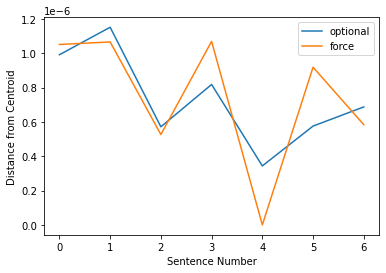

In [26]:
centroid_short = centroid_df_short.plot(y=['optional', 'force'], use_index=True, xlabel='Sentence Number', ylabel='Distance from Centroid')

### **Long Text**: Moon Landing Wikipedia

In [22]:
opt_centroids = metric_df2['distance_from_centroid_new'].tolist()
force_centroids = metric_df4['distance_from_centroid_new'].tolist()

d = {'optional':opt_centroids, 'force':force_centroids}
centroid_df_long = pd.DataFrame(d)

In [23]:
centroid_df_long

,optional,force
0,8.238540e-07,7.455302e-07
1,8.303863e-07,1.053106e-06
2,8.563083e-07,1.045982e-06
3,6.590503e-07,7.023164e-07
4,7.891666e-07,6.288535e-07
5,1.004437e-06,9.365969e-07
6,7.394742e-07,6.488395e-07
7,6.241676e-07,6.066341e-07
8,7.514797e-07,9.513656e-07
9,8.051106e-07,7.043371e-07


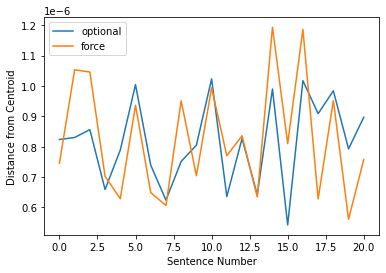

In [27]:
centroid_long = centroid_df_long.plot(y=['optional', 'force'], use_index=True, xlabel='Sentence Number', ylabel='Distance from Centroid')